In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix, classification_report, roc_auc_score
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from pycaret.classification import *
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
# df.groupby('SG_UF').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [ ]:
sns.heatmap(df.isnull())

In [5]:
# px.histogram(
#     df.groupby(['SG_UF','OBESIDADE']).size().reset_index(name='count').sort_values(by='count', ascending=False),
#     x='SG_UF',
#     y='count',
#     color='SG_UF')

In [6]:

# x = df.groupby('GARGANTA').size().reset_index(name='count').sort_values(by='count', ascending=False)

# px.histogram(
#      x,
#      x='GARGANTA',
#      y='count',
#      color='GARGANTA')
# x

In [7]:
# px.histogram(
#     df.groupby(['SG_UF','CS_SEXO']).size().reset_index(name='count').sort_values(by='count', ascending=False),
#     x='SG_UF',
#     y='count',
#     color='SG_UF')

In [8]:
# X_train = df.select_dtypes(['number']).drop(columns=['EVOLUCAO'])
# y_train = df['EVOLUCAO']

# X_test_sub = df_test.select_dtypes(['number'])

In [9]:
# X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size = .1, random_state=2)


In [10]:
# catb = CatBoostClassifier(
#     iterations=100,      
#     learning_rate=0.1,   
#     depth=6,              
#     verbose=0             
# )

# catb.fit(X_train, y_train)

# preds = catb.predict(X_test)

In [11]:
# catboost_accuracy = accuracy_score(y_test, preds)
# print(f"CatBoost's acurracy: {catboost_accuracy*100:.2f}%")

# print("\nClassification report")
# print(classification_report(y_test, preds))

# cm = confusion_matrix(y_test, preds)
# fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "CatBoost's Confusion Matrix"}, font=my_font).show()


In [12]:
# test_pred = catb.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

# pd.DataFrame(np.round(test_pred)).reset_index().to_csv('results/submission_catboost.csv', header=['ID', 'EVOLUCAO'], index=False)

In [13]:
# lightGBM = lgb.LGBMClassifier(random_state=23)

# lightGBM.fit(X_train, y_train)

# preds = lightGBM.predict(X_test)

In [14]:
# accuracy = lightGBM.score(X_test, y_test)


# print(f"LightGBM acurracy: {accuracy*100:.2f}%")
# print("\nClassification report")
# print(classification_report(y_test, preds))

# cm = confusion_matrix(y_test, preds)
# fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "LightGBM's Confusion Matrix"}, font=my_font).show()


In [15]:
# test_pred = lightGBM.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

# pd.DataFrame(np.round(test_pred)).reset_index().to_csv('results/submission_light_gbm.csv', header=['ID', 'EVOLUCAO'], index=False)

In [16]:
# rf = RandomForestClassifier()

# rf.fit(X_train, y_train)

In [17]:
# preds = rf.predict(X_test)
# accuracy = rf.score(X_test, y_test)

# print(f"Accuracy: {accuracy*100:.2f}")
# print("\nClassification report")
# print(classification_report(y_test, preds))

# cm = confusion_matrix(y_test, preds)
# fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "Random Forest's Confusion Matrix"}, font=my_font).show()



In [18]:
# xg = XGBClassifier()
# xg.fit(X_train, y_train)
# preds = xg.predict(X_test)


In [19]:
# accuracy = xg.score(X_test, y_test)

# print(f"Accuracy: {accuracy*100:.2f}")
# print("\nClassification report")
# print(classification_report(y_test, preds))

# cm = confusion_matrix(y_test, preds)
# fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "XGBoost's Confusion Matrix"}, font=my_font).show()


In [20]:
# test_pred = xg.predict_proba(X_test_sub)[:,1] # chances of death, class: 1.0

# pd.DataFrame(np.round(test_pred)).reset_index().to_csv('submission_xg.csv', header=['ID', 'EVOLUCAO'], index=False)

# Now we can try to treat this dataset
- Let us start by checking what columns have more missing values
- Then we can drop rows with more that 90% of the data NaN

In [21]:
# px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False),
#             x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
#              title="Most frequent columns with missing values").update_layout(font = my_font)

In [22]:
# x = df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False)
# x['pecentage_of_missing_data'] = (x['count'] / len(df))*100
# x

In [23]:
# px.histogram(df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=True).head(20),
#             x='index', y='count', color='count', color_discrete_sequence= px.colors.sequential.Plasma_r,
#              title="Less frequent columns with missing values").update_layout(font = my_font)

In [37]:
missing_counts = df.isnull().sum(axis=1)
thresh = 27
df_no_nulls = df[missing_counts < thresh]

### Note: You cannot just filter out all columns with ANY missing values
 - The accuracy of all models pretty much drops drastically

### Checking correlation between variables

In [25]:
# plt.figure(figsize=(12, 12))
# sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis', fmt=".1f")

## Frist, we can create a total_comorbities columns to represent the total amount of comordities one has.
    - We will separate it in chronic and temporary

In [128]:
df_no_nulls['total_chronic_cormodity'] = ((df_no_nulls[["OBESIDADE", 
                                                        "RENAL", 
                                                        "CARDIOPATI",
                                                        "IMUNODEPRE", 
                                                        "DIABETES", 
                                                        "PNEUMOPATI",
                                                        "HEPATICA",
                                                        "SIND_DOWN"]] == 1.0).sum(axis=1))

df_no_nulls['total_temporary_cormodity'] = (df_no_nulls[["FEBRE",
                                                        "TOSSE",
                                                        "PUERPERA",
                                                        "GARGANTA",
                                                        "DESC_RESP",
                                                        "DIARREIA",
                                                        "VOMITO",
                                                        "FADIGA",
                                                        "SATURACAO",
                                                        "DISPNEIA"]]== 1.0).sum(axis=1)

# Creating a function to handle missing values

In [131]:
class DataPreprocessor:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
    
    def fill_rows_with_ints(self, columns_to_fill, missing_value=0):
        for col in columns_to_fill:
            if col in self.df.columns:
                self.df[col] = self.df[col].fillna(missing_value)
                self.df[col] = self.df[col].astype(int)
        return self.df
    
    def fill_null_rows(self, columns_to_fill, missing_value):
        for col in columns_to_fill:
            if col in self.df.columns:
                self.df[col] = self.df[col].fillna(missing_value)
                self.df[col] = self.df[col].astype('category')

        return self.df

preprocessor = DataPreprocessor(df_no_nulls)
preprocessor_test = DataPreprocessor(df_test)

columns_to_fill = df_no_nulls.select_dtypes(['float']).columns.tolist()

processed_df = preprocessor.fill_rows_with_ints(columns_to_fill, missing_value=9)
processed_df_test = preprocessor_test.fill_rows_with_ints(columns_to_fill, missing_value=9)

In [132]:
columns_to_fill = [
                   "OBESIDADE", 
                   "RENAL", 
                   "CARDIOPATI",
                   "IMUNODEPRE", 
                   "DIABETES", 
                   "PNEUMOPATI",
                   "HEPATICA",
                   "FEBRE",
                   "TOSSE",
                   "GARGANTA",
                   "DESC_RESP",
                   "DIARREIA",
                   "VOMITO",
                   "FADIGA",
                   "SATURACAO",
                   "DISPNEIA",
                   "CS_RACA",
                   "CS_ZONA",
                   "VACINA",
                   "CS_ESCOL_N",
                   "FATOR_RISC",
                   "SIND_DOWN",
                   "CO_RG_RESI",
                   "PUERPERA",
                   "CS_SEXO",
                   "SG_UF",
                   "EVOLUCAO",
                   "CS_GESTANT"
                  ] # 22 columns 

preprocessor = DataPreprocessor(processed_df)
preprocessor_test = DataPreprocessor(processed_df_test)

df_2 = preprocessor.fill_null_rows(columns_to_fill, 9)


df_test_copy = preprocessor_test.fill_null_rows(columns_to_fill, 9)

df_2.drop(columns={"DT_NOTIFIC", "ID_MN_RESI","OBES_IMC", "CO_RG_RESI"}, inplace=True)
df_test_copy.drop(columns={"DT_NOTIFIC", "ID_MN_RESI","OBES_IMC", "CO_RG_RESI"}, inplace=True)


X = df_2.drop(columns={'EVOLUCAO'})
y = df_2['EVOLUCAO']




In [85]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=32)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.19, random_state=32)
# Note: 0.25 * 0.8 = 0.20, so overall 60/20/20

In [106]:
# LightGBM uses integer column indices for categorical features
cat_features = [X.columns.get_loc(c) for c in X.select_dtypes(['category']).columns]

params = {
    'n_estimators': 150,          # equivalent to iterations
    'learning_rate': 0.05,
    'max_depth': 7,
    'random_state': 32,
    'extra_trees': True,
    'metric': 'binary_logloss',
    'min_data_in_leaf': 1000,
    'num_leaves': 30,
    'colsample_bytree': 0.7,       # similar to rsm
    'reg_alpha': 0.1,
    'reg_lambda': 6,               # L2 regularization
    'bagging_fraction': 0.7,       # subsample ratio (use with bagging_freq)
    'bagging_freq': 1,
    'metric': 'TotalF1',     # default eval metric
    'verbose': -1,
    'lambda_l1': 1.0,
        #'early_stopping_rounds':10,
    'verbose': -1

}

lgbm = lgb.LGBMClassifier(**params)

# Fit model
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_names=['validation'],
    eval_metric='binary_logloss'
    # categorical_feature=cat_features,
    # callbacks=[
    #     lgb.early_stopping(stopping_rounds=50),
    #     lgb.log_evaluation(period=50)
    # ]
)

# Prediction
y_pred = lgbm.predict_proba(X_valid)[:, 1]  # prob for class 1
print("Validation AUC:", roc_auc_score(y_valid, y_pred))




Validation AUC: 0.7959264104092194


/usr/local/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



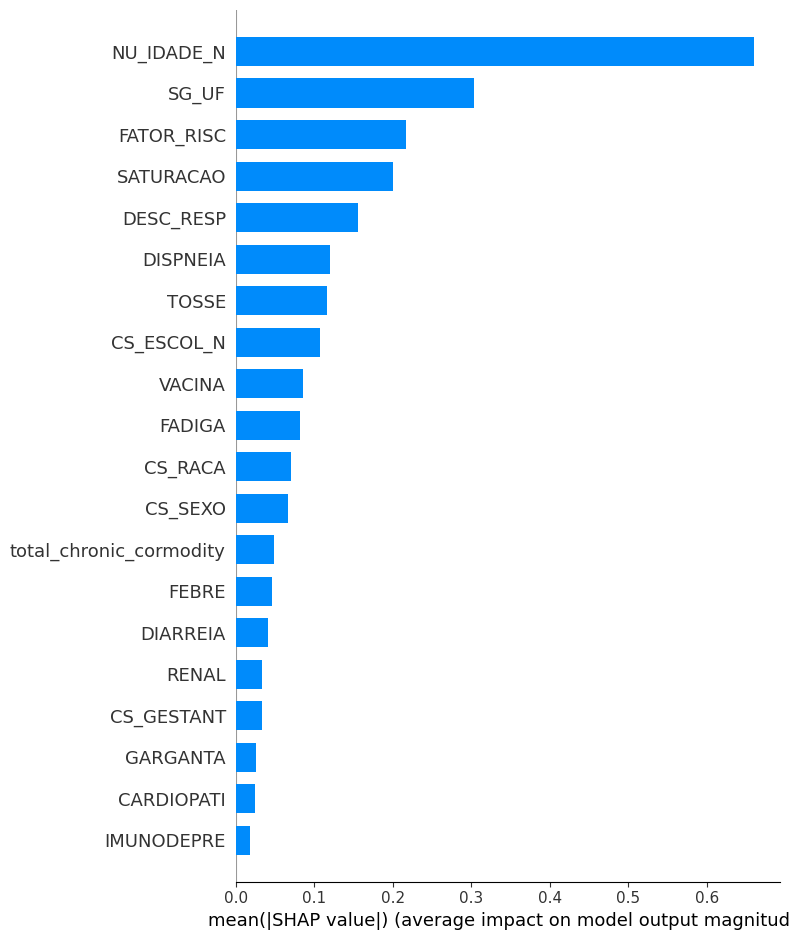

                      feature  importance
20                     VOMITO    0.004266
13                   HEPATICA    0.006031
26  total_temporary_cormodity    0.009721
1                     CS_ZONA    0.009870
8                  PNEUMOPATI    0.013858
11                  OBESIDADE    0.014841
7                    DIABETES    0.016362
9                  IMUNODEPRE    0.018161
12                 CARDIOPATI    0.025216
17                   GARGANTA    0.025491


In [137]:
import shap

# SHAP analysis
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, plot_type="bar")
shap_importance = np.abs(shap_values).mean(axis=0)

# put into DataFrame for readability
shap_importance_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": shap_importance
}).sort_values(by="importance", ascending=True)

print(shap_importance_df.head(10))   # lowest 10 features
# Drop low-impact features
# low_impact_features = [...]  # your list
# X_train_reduced = X_train.drop(columns=low_impact_features)
# X_valid_reduced = X_valid.drop(columns=low_impact_features)

# # Update categorical feature indices
# cat_features_reduced = [X_train_reduced.columns.get_loc(f) for f in cat_features if f not in low_impact_features]

# # Create LightGBM datasets
# train_data = lgb.Dataset(X_train_reduced, label=y_train, categorical_feature=cat_features_reduced)
# valid_data = lgb.Dataset(X_valid_reduced, label=y_valid, categorical_feature=cat_features_reduced, reference=train_data)

# # Train LightGBM
# model = lgb.train(
#     params,
#     train_data,
#     valid_sets=[train_data, valid_data],
#     valid_names=["train", "valid"],
#     num_boost_round=2000,
#     early_stopping_rounds=100
# )
# y_pred = model.predict_proba(X_valid)[:, 1]  # prob for class 1
# print("Validation AUC:", roc_auc_score(y_valid, y_pred))


### Now we will drop out unimportant feaures like SIND_DOWN    0.002544
###                 PUERPERA    0.005949
###                     CS_ZONA    0.007252

In [133]:
df_2.drop(columns={"SIND_DOWN", "PUERPERA", "VOMITO","HEPATICA"}, inplace=True)
df_test_copy.drop(columns={"SIND_DOWN", "PUERPERA", "VOMITO","HEPATICA"}, inplace=True)


X = df_2.drop(columns={'EVOLUCAO'})
y = df_2['EVOLUCAO']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=32)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.19, random_state=32)
# Note: 0.25 * 0.8 = 0.20, so overall 60/20/20



lgbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_names=['validation'],
    eval_metric='binary_logloss'
    # categorical_feature=cat_features,
    # callbacks=[
    #     lgb.early_stopping(stopping_rounds=50),
    #     lgb.log_evaluation(period=50)
    # ]
)

# Prediction
y_pred = lgbm.predict_proba(X_valid)[:, 1]  # prob for class 1
print("Validation AUC:", roc_auc_score(y_valid, y_pred))

Validation AUC: 0.7954410495030386


In [111]:

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=32)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.19, random_state=32)
# Note: 0.25 * 0.8 = 0.20, so overall 60/20/20


cat_features = X.select_dtypes(['category']).columns.tolist()
params = {
    'iterations':300,
    'learning_rate':0.05,
    'depth':7,
    'eval_metric':'TotalF1',
    'random_seed':32,
    'rsm': 0.7,
    'early_stopping_rounds': 10,
    'verbose': 50,
    'loss_function': 'MultiClass',
    'use_best_model': True,
    'l2_leaf_reg': 6,      # default 3, increase to reduce overfit
    'random_strength': 1.5,  # adds noise to splits
    'bagging_temperature': 2  
   #  'num_leaves': 50
}
ctb = CatBoostClassifier(
  **params
)

ctb.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
)

y_pred = ctb.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_valid, y_pred))

0:	learn: 0.6927041	test: 0.6915011	best: 0.6915011 (0)	total: 226ms	remaining: 1m 7s
50:	learn: 0.7188301	test: 0.7190782	best: 0.7190782 (50)	total: 11.1s	remaining: 54s
100:	learn: 0.7261066	test: 0.7266062	best: 0.7266062 (100)	total: 22.8s	remaining: 45s
150:	learn: 0.7293647	test: 0.7302183	best: 0.7302183 (150)	total: 34.7s	remaining: 34.3s
200:	learn: 0.7314475	test: 0.7314627	best: 0.7315802 (198)	total: 46.2s	remaining: 22.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.7319430836
bestIteration = 221

Shrink model to first 222 iterations.
Validation AUC: 0.7951334344315845


In [ ]:
preds = ctb.predict(X_test)

accuracy = ctb.score(X_test, y_test)


print(f"ctb acurracy: {accuracy*100:.2f}%")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "CatBoost's Confusion Matrix"}, font=my_font).show()


## Grid searching for the best params 

In [ ]:
# param_grid = {
#     'depth': [4, 6, 8],               # tree depth
#     'learning_rate': [0.01, 0.03, 0.05],  # step size
#     'l2_leaf_reg': [3, 5, 7],         # regularization
#     'bagging_temperature': [0, 0.5, 1], # randomness in bagging
#     'rsm': [0.7, 0.8, 1.0]            # fraction of features per tree
# }


# ctb = CatBoostClassifier(
#     iterations=500,
#     loss_function='Logloss',
#     eval_metric='TotalF1',
#     cat_features=cat_features,
#     verbose=0
# )

# randomized_search_result  = ctb.randomized_search(
#     param_grid,
#     X = X,
#     y= y,
#     plot=True
# )

# # rand_search.fit(X_train, y_train)
# # print("Best params:", rand_search.best_params_)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7295204011
bestIteration = 497

0:	loss: 0.7295204	best: 0.7295204 (0)	total: 2m	remaining: 18m 5s

bestTest = 0.7305163577
bestIteration = 498

1:	loss: 0.7305164	best: 0.7305164 (1)	total: 2m 51s	remaining: 11m 24s

bestTest = 0.7338701161
bestIteration = 498

2:	loss: 0.7338701	best: 0.7338701 (2)	total: 4m 15s	remaining: 9m 55s

bestTest = 0.7201615959
bestIteration = 499

3:	loss: 0.7201616	best: 0.7338701 (2)	total: 5m 7s	remaining: 7m 40s

bestTest = 0.7374203932
bestIteration = 442

4:	loss: 0.7374204	best: 0.7374204 (4)	total: 7m 15s	remaining: 7m 15s

bestTest = 0.7304318324
bestIteration = 496

5:	loss: 0.7304318	best: 0.7374204 (4)	total: 8m 15s	remaining: 5m 30s

bestTest = 0.7304318324
bestIteration = 496

6:	loss: 0.7304318	best: 0.7374204 (4)	total: 9m 15s	remaining: 3m 58s

bestTest = 0.7260419608
bestIteration = 496

7:	loss: 0.7260420	best: 0.7374204 (4)	total: 10m 51s	remaining: 2m 42s

bestTest = 0.7359003812
bestIteration = 484

8:	loss: 0.7359004	be

## Cross-validating the model

In [54]:
pool = Pool(data=X, label=y, cat_features=cat_features)

cv_results = cv(
    pool=pool,
    params=params,
    fold_count=5,               # number of folds
    shuffle=True,               # shuffle data before splitting
    partition_random_seed=42,   # reproducibility
    early_stopping_rounds=50,   # stop if no improvement
    verbose_eval=50
)

best_iter = cv_results['test-TotalF1-mean'].idxmax()
print("Best iteration:", best_iter)
print("Best CV F1:", cv_results['test-TotalF1-mean'].max())

Training on fold [0/5]
0:	learn: 0.6890425	test: 0.6896206	best: 0.6896206 (0)	total: 249ms	remaining: 4m 8s
50:	learn: 0.7131938	test: 0.7133284	best: 0.7133284 (50)	total: 9.64s	remaining: 2m 59s
100:	learn: 0.7193462	test: 0.7199987	best: 0.7199987 (100)	total: 19s	remaining: 2m 49s
150:	learn: 0.7238620	test: 0.7247549	best: 0.7247549 (150)	total: 28.9s	remaining: 2m 42s
200:	learn: 0.7271588	test: 0.7283898	best: 0.7283898 (200)	total: 38.9s	remaining: 2m 34s
250:	learn: 0.7293122	test: 0.7300268	best: 0.7301247 (247)	total: 48.5s	remaining: 2m 24s
300:	learn: 0.7308472	test: 0.7312906	best: 0.7313108 (298)	total: 58.2s	remaining: 2m 15s
350:	learn: 0.7319047	test: 0.7327376	best: 0.7327376 (350)	total: 1m 8s	remaining: 2m 5s
400:	learn: 0.7330814	test: 0.7332802	best: 0.7333009 (396)	total: 1m 17s	remaining: 1m 56s
450:	learn: 0.7340978	test: 0.7340119	best: 0.7340119 (450)	total: 1m 27s	remaining: 1m 46s
500:	learn: 0.7348353	test: 0.7350327	best: 0.7350327 (500)	total: 1m 37s	r

In [49]:
interaction_matrix = model.get_feature_importance(data=train_pool, type='FeatureImportance')
# feature_names = X_train.columns


# interaction_df = pd.DataFrame(interaction_matrix, index=X_train.columns, columns=X_train.columns)
# print(interaction_df)
interaction_matrix

array([ 1.64223865,  0.38781051, 30.10731473,  6.26197606,  2.82093822,
       15.94676638,  0.47171306,  0.24539617,  0.38671954,  0.48692894,
        1.049016  ,  1.89005966,  0.5136074 ,  0.87641147,  0.43125692,
        0.64507417,  3.89830398,  1.25179858,  3.20779504,  1.07320238,
        4.75534488,  1.22350926,  2.7685032 ,  6.01696663,  3.35789382,
        4.08702841,  2.62678236,  1.56964359])

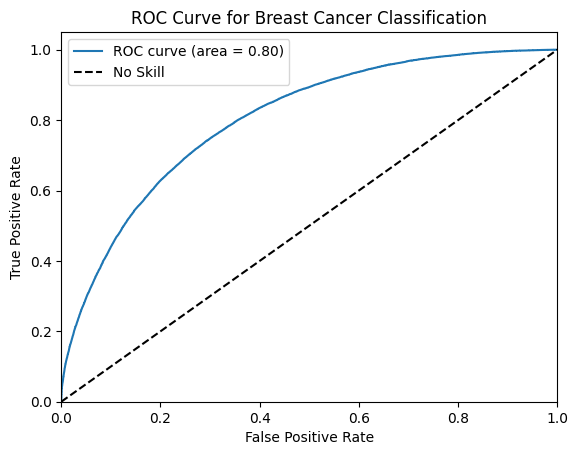

Boundary: 0.7491373932872102


In [17]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from catboost.utils import get_roc_curve, select_threshold

y_pred_proba = ctb.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

catboost_pool = Pool(X_train, y_train, cat_features=cat_features)



roc_curve_values = get_roc_curve(ctb, catboost_pool)

boundary = select_threshold(ctb,
                            curve=roc_curve_values,
                            FPR=0.01)

print("Boundary:",boundary)

In [134]:
df_test_copy['total_chronic_cormodity'] = ((df_test_copy[[        "OBESIDADE", 
                                                        "RENAL", 
                                                        "CARDIOPATI",
                                                        "IMUNODEPRE", 
                                                        "DIABETES", 
                                                        "PNEUMOPATI",
                                                        "HEPATICA",
                                                        #"SIND_DOWN"
                                                         ]] == 1.0).sum(axis=1))

df_test_copy['total_temporary_cormodity'] = (df_test_copy[[       "FEBRE",
                                                        "TOSSE",
                                                       # "PUERPERA",
                                                        "GARGANTA",
                                                        "DESC_RESP",
                                                        "DIARREIA",
                                                         "VOMITO",
                                                        "FADIGA",
                                                        "SATURACAO",
                                                        "DISPNEIA"]]== 1.0).sum(axis=1)


In [135]:
test_pred = lgbm.predict_proba(df_test_copy)[:,1]
test_pred

array([0.14616083, 0.14176305, 0.11690175, ..., 0.0244276 , 0.55931306,
       0.54145362], shape=(124581,))

In [136]:
pd.DataFrame(np.round(test_pred)).reset_index().to_csv('results/lightgbm_less_2_variables.csv', header=['ID', 'EVOLUCAO'], index=False)

In [89]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124581 entries, 0 to 124580
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   CS_SEXO                    124581 non-null  category
 1   CS_ZONA                    124581 non-null  category
 2   NU_IDADE_N                 124581 non-null  int64   
 3   CS_ESCOL_N                 124581 non-null  category
 4   CS_RACA                    124581 non-null  category
 5   SG_UF                      124581 non-null  category
 6   CS_GESTANT                 124581 non-null  category
 7   PUERPERA                   124581 non-null  category
 8   DIABETES                   124581 non-null  category
 9   PNEUMOPATI                 124581 non-null  category
 10  IMUNODEPRE                 124581 non-null  category
 11  RENAL                      124581 non-null  category
 12  OBESIDADE                  124581 non-null  category
 13  CARDIOPATI    